# Training a ConvNet and Explaining its Predictions

In this homework, we train a simple convolutional neural network on the CIFAR-10 dataset and explain its predictions in terms of input variables using sensitivity analysis and deep Taylor decomposition. The CIFAR-10 dataset is a common dataset for image recognition. Information for this dataset is available at the following page:

 * https://www.cs.toronto.edu/~kriz/cifar.html

We would like to train a convolutional neural network on this data. First, download the CIFAR-10 data at the following link:

 * https://www.cs.toronto.edu/~kriz/cifar-10-matlab.tar.gz

and uncompress the archive. The following code loads the 50000 CIFAR-10 training examples.

In [1]:
import numpy,scipy,scipy.io
Xtrain = []
Ttrain = []
for batch in [1,2,3,4,5]:
    D = scipy.io.loadmat('cifar-10-batches-mat/data_batch_%d'%batch)
    Xtrain += [(D['data']/127.5-1.0).reshape([-1,3,32,32]).transpose([0,2,3,1])]
    Ttrain += [(D['labels'][:,numpy.newaxis] == numpy.arange(10)).reshape([-1,1,1,10])*1.0]
    
Xtrain = numpy.concatenate(Xtrain,axis=0)
Ttrain = numpy.concatenate(Ttrain,axis=0)

Pixel values are between -1 and 1, and targets are represented as indicator vectors. The following code loads the first 500 test points (in this homework, for the sake of speed of evaluation, estimation of test error will be made on only 500 examples).


In [2]:
# Load test data
D = scipy.io.loadmat('cifar-10-batches-mat/test_batch')
Xtest = (D['data'][:500]/127.5-1.0).reshape([-1,3,32,32]).transpose([0,2,3,1])
Ttest = (D['labels'][:500][:,numpy.newaxis] == numpy.arange(10)).reshape([-1,1,1,10])

As a first step, the first 50 test examples are visualized.

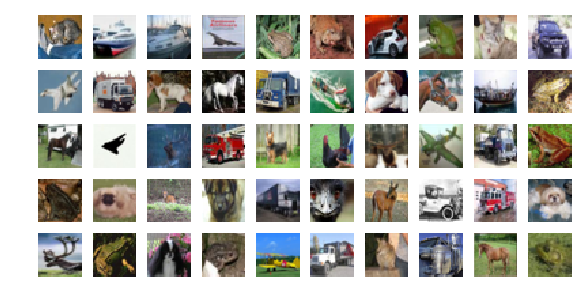

In [3]:
%matplotlib inline
import utils
utils.images(Xtest[:50])

### Build a Convolutional Neural Network (10 P)

We would like to build a simple convolutional neural network composed of convolution layers, interleaved with ReLU detection layers computing the function $\max(0,x)$ element-wise, and sum-pooling layers that sum activations in non-overlapping $2 \times 2$ windows. The network is shown below:

![Convolutional neural network](network.png)

Neural network code is in the file `modules.py`.

#### Tasks:

 * **Build the neural network above using the primitives from `modules.py`. The last layer should have weights initialized to zero.**
 
*(Hint: The last layer mapping the 250-dimensional activation vector to the 10 classes can also be written as a convolution.)*

In [4]:
import numpy
from modules import Network, Convolution, ReLU, Pooling

nn = Network([
    Convolution('cnn/c1-5x5x3x10', True),ReLU(),Pooling(),
    Convolution('cnn/c2-5x5x10x50', True),ReLU(),Pooling(),
    Convolution('cnn/c3-4x4x50x250', True),ReLU(),Pooling(),
    Convolution('cnn/c4-1x1x250x10', True)
])


### Implementing the Training Procedure (10 P)

The trainingstep function implements an iteration of stochastic gradient descent (SGD) and consists of 5 parts: (1) select a minibatch, (2) feed it to the network, (3) evaluate the gradient of the error function, (4) feed the gradient to the network, (5) update the parameters based on the gradient.

Let $y^{(n)} \in \mathbb{R}^{10}$ be the output of the neural network for some data point with index $n$. Class probabilities are modeled as:
$$
\forall_{i=1}^{10}: \quad p_i^{(n)} = \frac{\exp(y_i^{(n)})}{1+\sum_{j=1}^{10} \exp(y_j^{(n)})}
$$
The constant "1" in the denominator serves to model a default class, that is chosen if no evidence for other classes are found. It encourages the model to output values $y_i^{(n)} > 0$ for the correct class. The error for data point $n$ is then given by:
$$
\mathcal{E}^{(n)} = \sum_{i=1}^{10} - t_i^{(n)} \log p_i^{(n)}
$$
where $\boldsymbol{t}^{(n)}$ is an indicator vector of size $10$, which is one at the index of the correct class and zero elsewhere. At each step of training, the error gradient is computed for a minibatch of size $25$ composed of a random selection of data points in the training set.
$$
\mathcal{E} = \frac{1}{25}\sum_{n=1}^{25} \mathcal{E}^{(n)}
$$

#### Tasks:

* **Derive the gradient $\partial \mathcal{E} / \partial \boldsymbol{y}^{(n)}$.**
$$
    \frac{\partial \mathcal{E}}{\partial y^{(n)}} 
        = \left(\frac{\partial \mathcal{E}}{\partial y^{(n)}_k}\right)_k\\
    \frac{\partial \mathcal{E}}{\partial y^{(l)}_k}
        = \frac{1}{25}\sum_{i=1}^{10}-t_i^{(l)}\frac{1}{p_i^{(l)}}\frac{\partial p_i^{(l)}}{\partial y_i^{(l)}}\\
    \frac{\partial p_i^{(l)}}{\partial y_k^{(l)}}
        =  p_i^{(l)}1_{i=k} - {p_i^{(l)}}^2\exp\left(y_k^{(l)}-y_i^{(l)}\right)\\
    \frac{\partial \mathcal{E}}{\partial y^{(l)}_k}
        = \frac{1}{25}\sum_{i=1}^{10}-t_i^{(l)}\left[1_{i=k} - {p_i^{(l)}}\exp\left(y_k^{(l)}-y_i^{(l)}\right)\right]
        = \frac{1}{25}\sum_{i=1}^{10} t_i^{(l)}p_i^{(l)}\exp\left(y_k^{(l)}-y_i^{(l)}\right) - \frac{t_k^{(l)}}{25}
$$
* **Implement the method `geterrorgrad(y,t)` below, that receives the neural network output `y` and the target `t`, and computes the gradient of the error function with respect to the output of the network.**

Sorry for the bad implementation. We did not have the time to improve this properly.

In [5]:
def p_i(y,i):
    tmp = numpy.exp(y)
    return tmp[:,:,i]/(1+numpy.sum(tmp))
def geterrorgrad(y,t):
    dy=numpy.zeros(y.shape)
    I=numpy.eye(dy.shape[3])
    for l in range(dy.shape[0]):
        for k in range(dy.shape[3]):
            for i in range(dy.shape[3]):
                dy[l,:,:,k] += t[l,:,:,i]*p_i(y[l,:,:,:],i)*numpy.exp(y[l,:,:,k]-y[l,:,:,i])
            dy[l,:,:,k] -= t[l,:,:,k]
    dy /= 25
    return(dy)

def trainingstep():
    
    R = numpy.random.permutation(len(Xtrain))[:25]
    
    x,t = Xtrain[R],Ttrain[R]                      # 1. select random mini-batch
    y = nn.forward(x)                              # 2. forward pass
    dy = geterrorgrad(y,t)                         # 3. error gradient
    nn.gradprop(dy)                                # 4. backward pass
    nn.update(0.01)                                # 5. updating the parameters    

### Training the Neural Network (10 P)

The following code trains the convolutional neural network on the data for a certain number of iterations. At various checkpoints, the neural network is saved and the test error is being reported.

#### Tasks:

* **Train the neural network for at least 1000 iterations (this will typically take between 5 and 15 minutes, or more if you choose to train for more iterations).**

After 1000 iterations, the accuracy will still be low, but already much better than random (0.100). To achieve higher accuracy, many more training iterations and a larger model are needed. State-of-the-art neural networks are typically trained for several hours on GPUs.

In [6]:
cpt = [10,20,40,100,200,400,1000,2000,4000,6000,8000,10000,12000,14000,16000,18000,20000]

for i in range(1,2001):
    trainingstep()
    if i in cpt:
        nn.dump()                                      # 1. store the network
        pred=numpy.argmax(nn.forward(Xtest),axis=-1)   # 2. extract predicted classes
        targ=numpy.argmax(Ttest,axis=-1)               # 3. extract target classes
        print('%6d %.3f'%(i,(pred==targ).mean()))      # 4. compute classification accuracy

    10 0.100
    20 0.128
    40 0.164
   100 0.250
   200 0.268
   400 0.360
  1000 0.396
  2000 0.458


## Explaining the Predictions of the Trained Neural Network

The following code loads the neural network trained in the first part of the homework. *(Note: The code may need to be slightly adapted to match the name of the files in which you have stored the learned parameters.)*

In [4]:
import modules as md

cnn = md.Network([
    md.Convolution('cnn/c1-5x5x3x10'),md.ReLU(),md.Pooling(),
    md.Convolution('cnn/c2-5x5x10x50'),md.ReLU(),md.Pooling(),
    md.Convolution('cnn/c3-4x4x50x250'),md.ReLU(),md.Pooling(),
    md.Convolution('cnn/c4-1x1x250x10')
])

We first verify that the network correctly predicts the classes:

In [5]:
Ytest = cnn.forward(Xtest)
err=(numpy.argmax(Ytest,axis=-1) == numpy.argmax(Ttest,axis=-1)).mean()
print('Accuracy = %.3f'%err)

Accuracy = 0.458


We will focus on explaining the examples for which there is a lot of positive class evidence. We will select the points that have the maximum activations for their respective target class.

In [6]:
R = numpy.argsort(-(Ytest*Ttest).sum(axis=3).sum(axis=2).sum(axis=1))
X = Xtest[R][:50]
T = Ttest[R][:50]

These examples can be visualized.

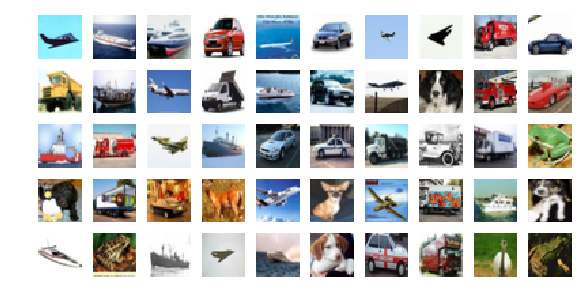

In [7]:
%matplotlib inline
import utils
utils.images(X)

### Sensitivity Analysis

Sensitivity analysis explains the evidence modeled by the neural network for class $i$ in terms of input variables, based on the simple gradient computation $\forall_p: S_p = \|\partial y_i / \partial x_p\|^2$, where the norm sums over the multiple components of each pixels (e.g. RGB values). The following code performs sensitivity analysis and displays the result as a heatmap.

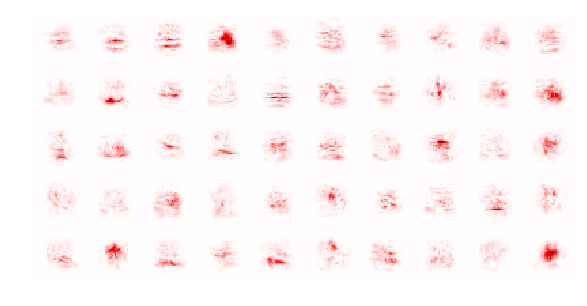

In [8]:
Y = cnn.forward(X)
S = (cnn.gradprop(T))**2
utils.heatmaps(S.sum(axis=3))

To test if the heatmaps align with the important pixels in the image, we can mask the image with the heatmap and check visually if class-irrelevant information has been removed, and class-relevant information kas been kept.

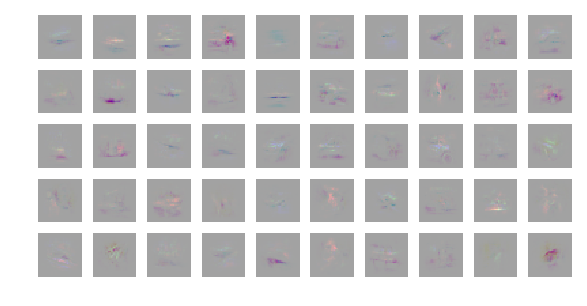

In [9]:
utils.images(X*S)

Here, it seems that the class-relevant information in the image is not correctly identified. Actually, sensitivity analysis tends to explain what makes the image more/less of a certain class rather than what makes the image of a certain class.

### Deep Taylor Decomposition (10 P)

Deep Taylor Decomposition is an explanation technique that seeks to explain the function's value directly. It relies on its own backward propagation mechanism. To implement it, we will extend each class of <a href="modules.py">`modules.py`</a>, and create specialized methods for propagation.

We first implement the global propagation procedure from the top to the bottom of the network. The class `Network` defined below extends the original neural network class and adds a method "`relprop`" that performs such propagation.

In [10]:
import modules

class Network(modules.Network):
    def relprop(self,R):
        for l in self.layers[::-1]:
            R = l.relprop(R)
        return R

The method iteratively visits layers of the network in reverse order, calls the propagation function of each individual layer, and feeds the output of each called function to the function of the previous layer. The code is similar to the one used to implement gradient propagation.

Relevance propagation operates at a higher level of granularity than standard gradient propagation. In particular, it considers as a layer the pairing of a linear and ReLU layer. Instead gradient propagation implementations typically treat them as two separate layers. One option would be to change the neural network implementation by merging these two layers into one. Alternatively, we can simply propagate the signal through the ReLU layer without transformation and implement the full propagation rule in the linear layer just below.

In [11]:
class ReLU(modules.ReLU):
    def relprop(self,R):
        return R

In linear layers and convolution layers, relevance is redistributed using the $z^+$-rule defined as:
$$
R_i = \sum_j \frac{x_i w_{ij}^+}{\sum_i x_i w_{ij}^+} R_j
$$
Here, $i$ and $j$ denote input and output neurons respctively, and $x_i$ is the ReLU activation of neuron $i$. The $z^+$-rule can also be expressed in terms by feedforward activation and gradient propagation.

In [12]:
import copy

class Convolution(modules.Convolution):
    
    def relprop(self,R):
        
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)
        Z = pself.forward(self.X)+1e-9
        S = R/Z
        C = pself.gradprop(S)
        R = self.X*C
        
        return R

Relevance propagation for sum-pooling layers can also be implemented following a similar idea.

In [13]:
class Pooling(modules.Pooling):
    def relprop(self,R):
        Z = (self.forward(self.X)+1e-9); S = R / Z
        C = self.gradprop(S);            R = self.X*C
        return R

For the first layer, we need a special rule, the $z^\mathcal{B}$-rule, which is specialized for layers that receive box-constrained input values, for example, pixel values. The rule is defined as:
$$
R_i = \sum_j \frac{x_i w_{ij} - h_i w_{ij}^- - l_i w_{ij}^+}{\sum_ix_i w_{ij} - h_i w_{ij}^- - l_i w_{ij}^+} R_j
$$
where $w_{ij}^+ = \max(0,w_{ij})$ and $w_{ij}^- = \min(0,w_{ij})$, and where $l_i=-1$ and $h_i=1$ are minimum and maximum input values.

#### Tasks:

 * **Implement the $z^\mathcal{B}$-rule. That is, create a class `FirstConvolution` that extends `modules.Convolution`, and implement the method relprop for that class.**

In [14]:
class FirstConvolution(modules.Convolution):
    def relprop(self,R):
        
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)
        Z = pself.forward(self.X)+1e-9
        S = R/Z
        C = pself.gradprop(S)
        R = self.X*C
        
        return R
    
    def forward(self,X):
        self.X = X
        mb,wx,hx,nx = X.shape
        ww,hw,nx,ny = self.W.shape
        wy,hy       = wx-ww+1,hx-hw+1

        Y = numpy.zeros([mb,wy,hy,ny],dtype='float32')

        for i in range(ww):
            for j in range(hw):
                W_max = numpy.maximum(0,self.W[i,j,:,:])
                W_min = numpy.minimum(0,self.W[i,j,:,:])
                WW = numpy.ones(W_max.shape)
                tmp = X[:,i:i+wy,j:j+hy,:]
                h = numpy.ones(tmp.shape)/numpy.prod(self.W[i,j,:,:].shape)
                h = numpy.zeros(tmp.shape)
                Y += numpy.dot(X[:,i:i+wy,j:j+hy,:],self.W[i,j,:,:])
                
                tmp = numpy.dot(h,WW)+1e-9
                Y -= numpy.dot(h,W_min)/tmp
                Y += numpy.dot(h,W_max)/tmp
        return Y+self.B

Now that all layers have been extended with the "`relprop`" function, a new network can be built based on these extended layers. 

In [15]:
cnn = Network([
    FirstConvolution('cnn/c1-5x5x3x10'),ReLU(),Pooling(),
    Convolution('cnn/c2-5x5x10x50'),ReLU(),Pooling(),
    Convolution('cnn/c3-4x4x50x250'),ReLU(),Pooling(),
    Convolution('cnn/c4-1x1x250x10'),ReLU()
])

The explanations are now computed by a simple call to the `relprop` function, where the argument given to this function is the evidence modeled by the neural network for the target class.

In [16]:
Y = cnn.forward(X)
D = cnn.relprop(Y*T)

The heatmaps can be visualized in the same way as for sensitivity analysis:

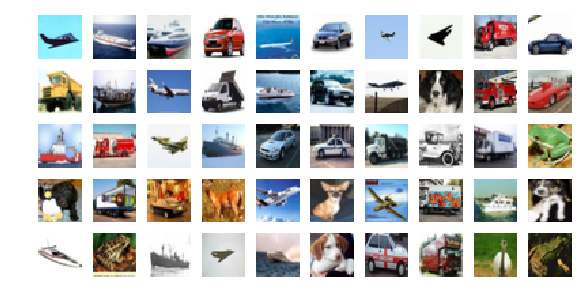

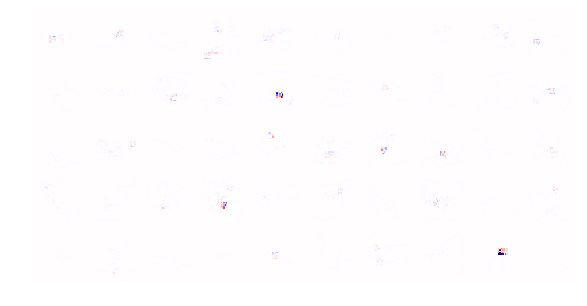

In [17]:
utils.images(X)
utils.heatmaps(D.sum(axis=3))

Heatmaps seem to better focus on class-relevant information (e.g. by extracting the contour or salient edges of objects). This can be verified by looking at the images masked by the heatmap.

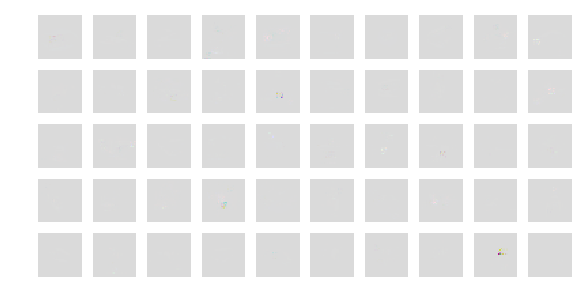

In [18]:
utils.images(X*D)